In [6]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os
import sys
import re
import warnings
import itertools
warnings.simplefilter(action='ignore', category=FutureWarning)
from tensorflow.keras.regularizers import l2
from tensorflow.keras import Input, Model
from tensorflow.keras.initializers import RandomUniform
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout, Conv1D, MaxPooling1D, Reshape, BatchNormalization
from tensorflow.keras.layers import AveragePooling1D, SeparableConv2D, Activation, concatenate, Conv2D
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.losses import KLDivergence
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.optimizers import SGD, Adam
from sklearn.metrics import mean_absolute_error, explained_variance_score, mean_squared_error, make_scorer
from sklearn.preprocessing import StandardScaler, MinMaxScaler, QuantileTransformer
from sklearn.linear_model import RidgeCV
from tensorflow.keras.constraints import non_neg
warnings.resetwarnings()

# CNN COVID-19 case number forecasting.

<!-- <img src="files/architecture2.png"> -->

# CNN Architecture

![title](conv_architecture.jpg)

# Function Declarations

In [62]:

def country_slice(data, locations):
    if type(locations)==str:
        return data[data.location==locations]
    else:
        return data[data.location.isin(locations)]
    
def time_slice(data, start, end, indexer='time_index'):
    if start < 0 and end < 0:
        if start == -1:
            start = data.loc[:, indexer].max()
        else:
            start = data.loc[:, indexer].max()+start
        if end == -1:
            end = data.loc[:, indexer].max()
        else:
            end = data.loc[:, indexer].max()+end
    return data[(data.loc[:, indexer] >= start) & (data.loc[:, indexer] <= end)]

def per_country_plot(data, feature, legend=True):
    data.set_index(['time_index', 'location']).loc[:, feature].unstack().plot(legend=legend)
    return None

def per_time_plot(data, feature, legend=True):
    data.set_index(['location','time_index']).loc[:, feature].unstack().plot(legend=legend)
    return None

def country_groupby(df):
    return [df[df.location==country].index for country in df.location.unique()]

def country_search(df, country):
    return df[df.location==country].index

def column_search(df, name, return_style='loc', threshold='contains'):
    if threshold=='contains':
        func = df.columns.str.contains
    else:
        func = df.columns.str.match
        
    if return_style == 'loc':
        return df.columns[func(name)]
    elif return_style== 'iloc':
        return np.where(func(name))[0]
    else:
        return None


    
    
def true_predict_plot(y_true, y_naive, y_predict, title='', suptitle='', scale=None,s=None):
    fig, (ax1,ax2) = plt.subplots(1, 2, figsize=(20,5))
    if scale == 'log':
        ymax = np.max([np.log(1+y_true).max(), np.log(1+y_predict).max()])
        ax1.scatter(np.log(y_true+1), np.log(y_naive+1), s=s,alpha=0.7)
        ax1.plot([0, ymax], [0, ymax],color='r')
        ax2.scatter(np.log(y_true+1), np.log(y_predict+1), s=s,alpha=0.7)
        ax2.plot([0, ymax], [0, ymax],color='r')
    else:
        ymax = np.max([y_true.max(), y_predict.max()])
        ax1.scatter(y_true, y_naive, s=s)
        ax1.plot([0, ymax], [0, ymax],color='r')
        ax2.scatter(y_true, y_predict, s=s)
        ax2.plot([0, ymax], [0, ymax],color='r')
    ax1.set_xlabel('True value')
    ax1.set_ylabel('Predicted value')
    ax1.set_title('Naive model')

    ax2.set_xlabel('True value')
    ax2.set_ylabel('Predicted value')
    ax2.set_title(title)
    ax1.grid(True)
    ax2.grid(True)
    plt.suptitle(suptitle)
    plt.show()
    return None

def residual_plot(y_test, y_predict, title='', ax=None):
    if ax is None:
        fig, ax = plt.subplots()
    ax.scatter(y_test, y_test-y_predict.ravel(), s=5)
    ax.set_ylabel('Residual')
    ax.set_xlabel('True value')
    ax.grid(True)
    return None

def residual_diff_plots(y_true, y_naive, y_predict,n_days_into_future, n_countries, scale=None):
    print(y_true.shape, y_naive.shape, y_predict.shape)
    fig, axes = plt.subplots(2, 2, figsize=(20,5), sharey=True)
    (ax1,ax2,ax3,ax4) = axes.flatten()
    xrange = range(len(y_true))
    if scale=='log':
        ax1.plot(xrange, np.log(y_true+1)
             -np.log(y_naive+1))
        ax2.plot(xrange, np.log(y_true+1)
                 -np.log(y_predict+1))
        residual_plot(np.log(y_true+1),np.log(y_naive+1), ax=ax3)
        residual_plot(np.log(y_true+1),np.log(y_predict+1), ax=ax4)
    else:
        ax1.plot(xrange, y_true-y_naive)
        ax2.plot(xrange, y_true-y_predict)
        residual_plot(y_true,y_naive, ax=ax3)
        residual_plot(y_true,y_predict, ax=ax4)
    fig.suptitle('{}-day-into-future predictions'.format(n_days_into_future))
    ax1.set_title('Country-wise differences')
    ax2.set_title('Country-wise differences')
    ax1.set_ylabel('True - Naive')
    ax2.set_ylabel('True - CNN')
    ax1.grid(True)
    ax2.grid(True)
    plt.show()
    return None


def create_Xy(model_data, target_data, time_index, start_date, frame_size, n_days_into_future, n_countries):
    for max_date_in_window in range(start_date, time_index.max() - n_days_into_future + 2):
        # Take all model_data with date proxy less than numerical value, leading_window_date_not_included
        frame_data = model_data[(time_index <= max_date_in_window-1) & 
                                (time_index >= max_date_in_window-frame_size)]
        #     print(frame_data.shape)
        # Reshape the array such that each element along axis=0 is a time series of all feature model_data of a specific country.
        reshaped_frame_data = frame_data.values.reshape(n_countries, frame_size, -1)
#         print(reshaped_frame_data.shape)
        #     print(reshaped_frame_data.shape)
        # Truncate / pad the windows along the "time" axis, axis=1. (pad_sequences takes in an iterable of iterables;
        # the first axis is always the default iteration axis. 
        # *********************** WARNING: pad_sequences converts to integers by default *********************
        resized_frame_data = pad_sequences(reshaped_frame_data, maxlen=frame_size, dtype=np.float64)
        frame_data_4D = resized_frame_data[np.newaxis, :, :, :]
        if max_date_in_window == start_date:
            print('Starting with frame ranging time_index values:', max_date_in_window-frame_size, max_date_in_window - 1)
            X = frame_data_4D.copy()
        else:
            X = np.concatenate((X, frame_data_4D),axis=0)
    print('Ending with frame ranging time_index values:', max_date_in_window-frame_size, max_date_in_window - 1)
    y = target_data.values.reshape(-1, time_index.nunique()).transpose()[-X.shape[0]:,:]
    return X, y

def split_Xy(X, y, frame_size, n_validation_frames, n_test_frames, train_test_only=False, model_type='cnn'):
    """ Split into training, validation and test data.
    """
    
    # the indices for the train-validate-test splits for when the predictors are put in a 2-d format.
    train_indices = list(range(n_countries*0, n_countries*(len(X)-(n_validation_frames+n_test_frames))))
    validate_indices = list(range(n_countries*(len(X)-(n_validation_frames+n_test_frames)), n_countries*(len(X)-n_test_frames)))
    test_indices = list(range(n_countries*(len(X)-n_test_frames), n_countries*len(X)))
    indices = (train_indices, validate_indices, test_indices)

    # Note that the last frame (date_range) that exists in X has already been determined by the choice of the number
    # of steps to predict in the future, this is only slicing the frames. 
    if train_test_only:
        X_train= X[:-n_test_frames,:,:,:]
        y_train =  y[:-n_test_frames,:]
        X_test = X[-n_test_frames:, :, :, :] 
        y_test = y[-n_test_frames:, :]
        splits =  (X_train, y_train, X_test, y_test)
    else:
        y_train =  y[:-(n_validation_frames+n_test_frames),:]
        y_validate = y[-(n_validation_frames+n_test_frames):-n_test_frames, :]
        X_train= X[:-(n_validation_frames+n_test_frames),:,:,:]
        y_train =  y[:-(n_validation_frames+n_test_frames),:]
        X_validate = X[-(n_validation_frames+n_test_frames):-n_test_frames, :, :, :]
        y_validate = y[-(n_validation_frames+n_test_frames):-n_test_frames, :]
        X_test = X[-n_test_frames:, :, :, :] 
        y_test = y[-n_test_frames:, :]
        splits =  (X_train, y_train, X_validate, y_validate,
                   X_test, y_test)

    return splits, indices


def normalize_Xy_splits(splits, feature_range=(0., 0.5), normalization_method='minmax',
                        train_test_only=False, feature_indices=None):
    """ Split into training, validation and test data.
    """
    min_, max_ = (0, 0.5)
    (X_train, y_train, X_validate, y_validate, X_test, y_test) = splits
    for i in range(1, X_train.shape[0]+1):
        # find the minima and maxima of all features for all countries, ranging up to current frame and 
        # each time step in the frame. 
        up_to_current_frame_min = X_train[:i,:,:,:].min((0,1,2))
        up_to_current_frame_max = X_train[:i,:,:,:].max((0,1,2))
        latest_min_array = np.tile(up_to_current_frame_min[np.newaxis, np.newaxis, np.newaxis, :],(1,n_countries,frame_size,1))
        latest_max_array = np.tile(up_to_current_frame_max[np.newaxis, np.newaxis, np.newaxis, :],(1,n_countries,frame_size,1))
        if i == 1:
            frame_min_array = latest_min_array
            frame_max_array = latest_max_array
        else:
            frame_min_array = np.concatenate((frame_min_array, 
                                                   latest_min_array)
                                                  ,axis=0)
            frame_max_array = np.concatenate((frame_max_array, 
                                                   latest_max_array)
                                                  ,axis=0)

    # frame_min_array = np.tile(frame_min_array, (1, n_countries, 1, 1))
    # frame_max_array = np.tile(frame_max_array, (1, n_countries, 1, 1))

    minmax_denominator = (frame_max_array-frame_min_array)
    minmax_denominator[np.where(minmax_denominator==0)]=1
    X_train_scaled = (max_-min_)*(X_train - frame_min_array) / minmax_denominator
    # Use the latest min and max for test scaling.

    latest_minmax_denominator = latest_max_array - latest_min_array
    latest_minmax_denominator[np.where(latest_minmax_denominator==0)] = 1
    X_validate_scaled = (max_- min_)*((X_validate - np.tile(latest_min_array,(n_validation_frames,1,1,1)))
                                        / np.tile(latest_minmax_denominator,(n_validation_frames,1,1,1)))
    X_test_scaled = (max_- min_)*((X_test - np.tile(latest_min_array,(n_test_frames,1,1,1))) 
                                        / np.tile(latest_minmax_denominator,(n_test_frames,1,1,1)))
    scaled_splits = (X_train_scaled, y_train, X_validate_scaled, y_validate, X_test_scaled, y_test) 

    train_norm_arrays =  (frame_max_array, frame_min_array, minmax_denominator)
    validate_and_test_norm_arrays = (latest_max_array,latest_min_array,latest_minmax_denominator)

    return scaled_splits, train_norm_arrays, validate_and_test_norm_arrays

def flatten_Xy_splits(splits):
    (X_train, y_train, X_validate, y_validate, X_test, y_test) = splits
    X_train_flat =np.concatenate(X_train.reshape(X_train.shape[0], X_train.shape[1], -1), axis=0)
    X_validate_flat =np.concatenate(X_validate.reshape(X_validate.shape[0], X_validate.shape[1], -1), axis=0)
    X_test_flat =np.concatenate(X_test.reshape(X_test.shape[0], X_test.shape[1], -1), axis=0)
    y_train_flat = y_train.ravel()
    y_validate_flat = y_validate.ravel()
    y_test_flat = y_test.ravel()
    flat_splits = (X_train_flat , y_train_flat , X_validate_flat , y_validate_flat , X_test_flat , y_test_flat )
    return flat_splits

def model_analysis(y_true, y_naive, y_predict,n_countries, title='',suptitle=''):
    print('There were {} negative predictions'.format(len(y_predict[y_predict<0])))
    #     y_predict[y_predict<0]=0
    mse_train_naive = mean_squared_error(y_true.ravel(), y_naive.ravel())
    mse_predict = mean_squared_error(y_true.ravel(), y_predict)
    r2_train_naive = explained_variance_score(y_true.ravel(), y_naive.ravel())
    r2_predict = explained_variance_score(y_true.ravel(), y_predict)

    print('{}-step MSE [Naive, {}] = [{},{}]'.format(
    n_days_into_future,title, mse_train_naive, mse_predict))
    print('{}-step R^2 [Naive, {}] = [{},{}]'.format(
    n_days_into_future,title, r2_train_naive, r2_predict))

    true_predict_plot(y_true.ravel(), y_naive.ravel(), y_predict, title=title, suptitle=suptitle)
    residual_diff_plots(y_true.ravel(), y_naive.ravel(), y_predict , n_days_into_future, n_countries)
    return None

def concatenate_4d_into_3d(splits, train_test_only=False):
    
    if train_test_only:
        (X_train, y_train, X_test, y_test) = splits
        X_train = np.concatenate(X_train, axis=0)
        y_train = np.concatenate(y_train, axis=0)
        X_test = np.concatenate(X_test, axis=0)
        y_test = np.concatenate(y_test, axis=0)
        concat_splits = (X_train, y_train, X_test, y_test) 
    else:
        (X_train, y_train, X_validate, y_validate, X_test, y_test) = splits
        X_train = np.concatenate(X_train, axis=0)
        y_train = np.concatenate(y_train, axis=0)
        X_validate = np.concatenate(X_validate, axis=0)
        y_validate = np.concatenate(y_validate, axis=0)
        X_test = np.concatenate(X_test, axis=0)
        y_test = np.concatenate(y_test, axis=0)
        concat_splits = (X_train, y_train, X_validate, y_validate, X_test, y_test) 
    return concat_splits

# Data

# use the new version of the data, filling zeros.

A quick synopsis of the data. This data contains time series data for 10 features for 103 separate countries Because of how unfairly very small countries are weighted, the countries smaller than 25th percentile of population were removed.

First course of action is to decide on the format of the inputs. For now, focus on 1-D convolution only.
Need to decide on the dimension of the inputs. The typical format is (batch size, time steps, n_features). 
Two quick ideas :

I think the simplest is to just find all windows of length $n$ for all countries such that the input dimension would be
input_dim = (n_countries * n_windows, window_size, n_features) 

The other idea I had would be to do (n_windows, n_countries, window_size, n_features), and then the output would be the future values for each country.

Just do the first for now. Also, just do a one-step model for now.

Want to predict n_cases_weighted (weighted by the percentage of the population that the country consists of. Might be a dumb idea.)

In [21]:
# Import cleaned data produced by other notebook. 
data = pd.read_csv('cnn_data.csv',index_col=0)

In [22]:
n_countries = data.location.nunique()
n_dates = data.time_index.nunique()
n_countries, n_dates

(134, 161)

In [23]:
# not enough countries have new_recovered_weighted values.
data = data.drop(columns=['date'])
data = data.drop(columns=column_search(data, 'log'))
# this is just a convenience thing for slicing later on.
# data.loc[:, 'time_index'] += 1

Too many params causes issues

works well: 

    lower number of parameters, 
    log scaling
    new_weighted_quantities only, 
    no minmax scaling
    start date 32, 
    7 validation, 
    1 test
    epochs 10
    learning_rate 0.001
    n_days_into_future = 1
    n_validation_frames = 7
    n_test_frames = 1
    predict_steps = [1]
    f = (32, 8)
    k = (4, 4)
    epochs = 10
    batch_size = 128
    
    seems to do the best with fewer parameters and no contraction between last conv layer and dense layer. 

# main difference between this and model prototyping

The data being used, and the parameters being tuned; it was the architecture that was mainly tested previously in the
prototyping notebook.

In [247]:
# data = data[data.time_index>=40]
model_data = data.copy().iloc[:, 3:]
model_data =  model_data#.apply(lambda x :np.log(x+1))
new_cases_index = column_search(model_data,'new_cases_per_million', threshold='match', return_style='iloc')[0]
# model_data = model_data.iloc[:, new_cases_index].to_frame(); new_cases_index=0
n_countries = data.location.nunique()
target_data = model_data.new_cases_per_million
time_index = data.time_index

frame_size = 28
start_date = frame_size

n_validation_frames = 7
n_test_frames = 1
n_days_into_future = 1

In [248]:
X, y = create_Xy(model_data, target_data, time_index, start_date, frame_size, n_days_into_future, n_countries)
splits, indices = split_Xy(X, y, frame_size, n_validation_frames, n_test_frames)
# if need to supply folds for sklearn CV regression functions.
(X_train, y_train, X_validate, y_validate, X_test, y_test) = splits
(train_indices, validate_indices, test_indices) = indices

scaled_splits, frame_minmax, latest_minmax =  normalize_Xy_splits(splits, feature_range=(0,0.5), 
                                                                  normalization_method='minmax',
                                                                  train_test_only=False,
                                                                  feature_indices=None)
(latest_max, latest_min, latest_denom) = latest_minmax
(frame_max, frame_min, frame_denom) = frame_minmax
(X_cnn_train, y_cnn_train, X_cnn_validate, y_cnn_validate, X_cnn_test, y_cnn_test) = splits

splits_3d = concatenate_4d_into_3d(splits)
(X_cnn_train_model,y_cnn_train_model,X_cnn_validate_model,
 y_cnn_validate_model,X_cnn_test_model,y_cnn_test_model) = splits_3d
X_for_naive_slicing = np.concatenate(X.reshape(X.shape[0], X.shape[1], -1), axis=0)
n_features = X.shape[-1]
last_day_new_cases_index = np.ravel_multi_index([[frame_size-1],[new_cases_index]],(frame_size, n_features))
y_train_naive = X_for_naive_slicing[train_indices, last_day_new_cases_index].ravel()
y_validate_naive =  X_for_naive_slicing[validate_indices, last_day_new_cases_index].ravel()
y_test_naive =  X_for_naive_slicing[test_indices, last_day_new_cases_index].ravel()
# y_train_naive = (np.exp(X_for_naive_slicing[train_indices, last_day_new_cases_index])-1).ravel()
# y_validate_naive =  (np.exp(X_for_naive_slicing[validate_indices, last_day_new_cases_index])-1).ravel()
# y_test_naive =  (np.exp(X_for_naive_slicing[test_indices, last_day_new_cases_index])-1).ravel()

Starting with frame ranging time_index values: 0 27
Ending with frame ranging time_index values: 132 159


In [250]:
model_data.columns

Index(['new_cases_per_million', 'new_tests_per_million',
       'new_recovered_per_million', 'new_deaths_per_million'],
      dtype='object')

In [264]:
epochs = 1000
laearning_rate = 0.01
kernel = 4
N = 8
FC = 8
batch_size = 256

f1, f2 = 64, 16
k1, k2 = 4, 4

cnn_model = Sequential()
# kernel_initializer0=RandomUniform(minval=0.0, 
#                                  maxval= 1.0,
#                                  seed=0,
#                                 dtype=float)

cnn_model.add(Conv1D(filters=int(f1), kernel_size=int(k1),
                 padding='valid',
                 input_shape=X_cnn_train.shape[2:],
                 use_bias=False,
#                 kernel_constraint=non_neg(),
#                  activation='relu',
#                 kernel_initializer=kernel_initializer0
                )
         )

cnn_model.add(AveragePooling1D(pool_size=3))
# cnn_model.add(Activation('relu'))
# kernel_initializer1=RandomUniform(minval=0.0, 
#                                  maxval= 1.0,
#                                  seed=0,
#                                 dtype=float)

cnn_model.add(Conv1D(filters=int(f2), 
                 kernel_size=int(k2), 
                 padding='valid',
                 use_bias=False,
#                  kernel_constraint=non_neg(),

#                  activation='relu',
#                 kernel_initializer=kernel_initializer1
#                   use_bias=False
                )
         )


cnn_model.add(AveragePooling1D(pool_size=3))
# cnn_model.add(Activation('relu'))
cnn_model.add(Flatten())

# kernel_initializer2=RandomUniform(minval=0.0, 
#                                  maxval= 1.0,
#                                  seed=2,
#                                 dtype=float)

# cnn_model.add(Dense(, 
# #                 activation='relu',
#                 use_bias=False,
# #                  kernel_constraint=non_neg(),
# #                 kernel_initializer=kernel_initializer2
#                )
#          )

cnn_model.add(Dense(np.min([n_countries,cnn_model.output.shape[1]]),
#                 activation='relu',
                use_bias=False,
#                  kernel_constraint=non_neg(),
#                 kernel_initializer=kernel_initializer2
               )
         )

# kernel_initializer3=RandomUniform(minval=0.0, 
#                                  maxval= 1.0,
#                                  seed=0,
#                                 dtype=float)

cnn_model.add(Dense(1, 
                    activation='relu',
                    use_bias=False,
                     kernel_constraint=non_neg(),
#                     kernel_initializer=kernel_initializer3
                   ))
cnn_model.compile(loss='mse', optimizer=Adam(learning_rate=learning_rate))

In [265]:
cnn_model.summary()

Model: "sequential_34"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_67 (Conv1D)           (None, 25, 64)            1024      
_________________________________________________________________
average_pooling1d_4 (Average (None, 8, 64)             0         
_________________________________________________________________
conv1d_68 (Conv1D)           (None, 5, 16)             4096      
_________________________________________________________________
average_pooling1d_5 (Average (None, 1, 16)             0         
_________________________________________________________________
flatten_33 (Flatten)         (None, 16)                0         
_________________________________________________________________
dense_66 (Dense)             (None, 16)                256       
_________________________________________________________________
dense_67 (Dense)             (None, 1)               

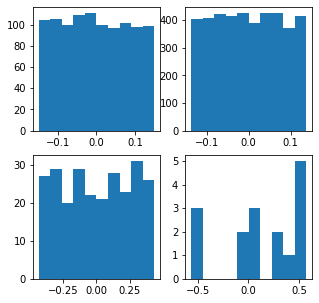

In [266]:
fig, axes = plt.subplots(2,2, figsize=(5,5))
(ax1,ax2,ax3,ax4) = axes.flatten()
_ = ax1.hist(cnn_model.get_weights()[0].ravel())
_ = ax2.hist(cnn_model.get_weights()[1].ravel())
_ = ax3.hist(cnn_model.get_weights()[2].ravel())
_ = ax4.hist(cnn_model.get_weights()[3].ravel())
plt.show()

In [267]:
history = cnn_model.fit(X_cnn_train_model, y_cnn_train_model, epochs=epochs, validation_data=(X_cnn_validate_model, y_cnn_validate_model), 
          batch_size=batch_size, verbose=1)

Train on 16750 samples, validate on 938 samples
Epoch 1/1000
16750/16750 [==============================] - 1s 83us/sample - loss: 2232.3971 - val_loss: 4498.1562
Epoch 2/1000
16750/16750 [==============================] - 1s 31us/sample - loss: 2213.8842 - val_loss: 4498.1559
Epoch 3/1000
16750/16750 [==============================] - 1s 30us/sample - loss: 2213.7592 - val_loss: 4498.1563
Epoch 4/1000
16750/16750 [==============================] - 1s 31us/sample - loss: 2213.7420 - val_loss: 4498.1438
Epoch 5/1000
16750/16750 [==============================] - 1s 30us/sample - loss: 2213.6419 - val_loss: 4498.0941
Epoch 6/1000
16750/16750 [==============================] - 1s 30us/sample - loss: 2205.3638 - val_loss: 4300.3565
Epoch 7/1000
16750/16750 [==============================] - 1s 30us/sample - loss: 1184.7670 - val_loss: 911.2471
Epoch 8/1000
16750/16750 [==============================] - 1s 30us/sample - loss: 767.3102 - val_loss: 1448.1738
Epoch 9/1000
16750/16750 [========

16750/16750 [==============================] - 1s 30us/sample - loss: 506.4011 - val_loss: 728.1937
Epoch 73/1000
16750/16750 [==============================] - 1s 30us/sample - loss: 506.5433 - val_loss: 839.5936
Epoch 74/1000
16750/16750 [==============================] - 0s 30us/sample - loss: 524.8341 - val_loss: 747.3585
Epoch 75/1000
16750/16750 [==============================] - 1s 30us/sample - loss: 537.7625 - val_loss: 741.9859
Epoch 76/1000
16750/16750 [==============================] - 1s 30us/sample - loss: 524.9099 - val_loss: 1041.4929
Epoch 77/1000
16750/16750 [==============================] - ETA: 0s - loss: 344.997 - 1s 31us/sample - loss: 505.0010 - val_loss: 801.1021
Epoch 78/1000
16750/16750 [==============================] - 1s 30us/sample - loss: 509.8911 - val_loss: 720.1438
Epoch 79/1000
16750/16750 [==============================] - 1s 31us/sample - loss: 509.4419 - val_loss: 723.0511
Epoch 80/1000
16750/16750 [==============================] - 1s 31us/sample

16750/16750 [==============================] - 0s 30us/sample - loss: 483.2602 - val_loss: 822.1850
Epoch 144/1000
16750/16750 [==============================] - 1s 31us/sample - loss: 477.2305 - val_loss: 798.3922
Epoch 145/1000
16750/16750 [==============================] - 1s 31us/sample - loss: 481.3982 - val_loss: 793.4202
Epoch 146/1000
16750/16750 [==============================] - 0s 30us/sample - loss: 476.7615 - val_loss: 806.2615
Epoch 147/1000
16750/16750 [==============================] - 1s 31us/sample - loss: 482.3665 - val_loss: 884.0905
Epoch 148/1000
16750/16750 [==============================] - 1s 31us/sample - loss: 482.0257 - val_loss: 838.8544
Epoch 149/1000
16750/16750 [==============================] - 1s 32us/sample - loss: 472.9524 - val_loss: 813.8345
Epoch 150/1000
16750/16750 [==============================] - 1s 32us/sample - loss: 474.9835 - val_loss: 838.9186
Epoch 151/1000
16750/16750 [==============================] - 1s 31us/sample - loss: 490.9195 -

16750/16750 [==============================] - 1s 33us/sample - loss: 464.7931 - val_loss: 855.2011
Epoch 215/1000
16750/16750 [==============================] - 1s 34us/sample - loss: 454.4150 - val_loss: 866.0197
Epoch 216/1000
16750/16750 [==============================] - 1s 33us/sample - loss: 461.8152 - val_loss: 960.7057
Epoch 217/1000
16750/16750 [==============================] - 1s 33us/sample - loss: 471.3792 - val_loss: 954.4084
Epoch 218/1000
16750/16750 [==============================] - 1s 33us/sample - loss: 463.8738 - val_loss: 877.6620
Epoch 219/1000
16750/16750 [==============================] - 1s 33us/sample - loss: 459.4768 - val_loss: 877.6689
Epoch 220/1000
16750/16750 [==============================] - 1s 33us/sample - loss: 460.3888 - val_loss: 920.4531
Epoch 221/1000
16750/16750 [==============================] - 1s 33us/sample - loss: 463.7736 - val_loss: 947.5638
Epoch 222/1000
16750/16750 [==============================] - 1s 33us/sample - loss: 461.0453 -

16750/16750 [==============================] - 1s 33us/sample - loss: 446.4123 - val_loss: 1102.8616
Epoch 286/1000
16750/16750 [==============================] - 1s 33us/sample - loss: 448.8580 - val_loss: 950.4352
Epoch 287/1000
16750/16750 [==============================] - 1s 32us/sample - loss: 449.2372 - val_loss: 964.9752
Epoch 288/1000
16750/16750 [==============================] - 1s 33us/sample - loss: 469.3870 - val_loss: 1062.0840
Epoch 289/1000
16750/16750 [==============================] - 1s 33us/sample - loss: 446.6556 - val_loss: 959.2066
Epoch 290/1000
16750/16750 [==============================] - 1s 33us/sample - loss: 447.8215 - val_loss: 975.9307
Epoch 291/1000
16750/16750 [==============================] - 1s 33us/sample - loss: 442.9516 - val_loss: 986.7718
Epoch 292/1000
16750/16750 [==============================] - 1s 35us/sample - loss: 457.7267 - val_loss: 947.6410
Epoch 293/1000
16750/16750 [==============================] - 1s 34us/sample - loss: 450.6771

16750/16750 [==============================] - 0s 30us/sample - loss: 444.1480 - val_loss: 1028.2017
Epoch 357/1000
16750/16750 [==============================] - 1s 30us/sample - loss: 434.4543 - val_loss: 1027.1792
Epoch 358/1000
16750/16750 [==============================] - 0s 30us/sample - loss: 437.1257 - val_loss: 1055.4924
Epoch 359/1000
16750/16750 [==============================] - 0s 30us/sample - loss: 439.7593 - val_loss: 996.5818
Epoch 360/1000
16750/16750 [==============================] - 1s 30us/sample - loss: 434.3491 - val_loss: 997.5225
Epoch 361/1000
16750/16750 [==============================] - 1s 30us/sample - loss: 442.6504 - val_loss: 1010.3512
Epoch 362/1000
16750/16750 [==============================] - 0s 30us/sample - loss: 433.7598 - val_loss: 1065.8982
Epoch 363/1000
16750/16750 [==============================] - 1s 30us/sample - loss: 436.7807 - val_loss: 1104.3039
Epoch 364/1000
16750/16750 [==============================] - 0s 30us/sample - loss: 445.

Epoch 427/1000
16750/16750 [==============================] - 1s 34us/sample - loss: 432.6187 - val_loss: 1158.0996
Epoch 428/1000
16750/16750 [==============================] - 1s 33us/sample - loss: 426.6890 - val_loss: 1138.9310
Epoch 429/1000
16750/16750 [==============================] - 1s 33us/sample - loss: 447.3680 - val_loss: 1087.2434
Epoch 430/1000
16750/16750 [==============================] - 1s 33us/sample - loss: 423.1762 - val_loss: 1076.7749
Epoch 431/1000
16750/16750 [==============================] - 1s 33us/sample - loss: 436.0964 - val_loss: 1083.7375
Epoch 432/1000
16750/16750 [==============================] - 1s 33us/sample - loss: 426.4434 - val_loss: 1081.5936
Epoch 433/1000
16750/16750 [==============================] - 1s 33us/sample - loss: 431.3231 - val_loss: 1147.2643
Epoch 434/1000
16750/16750 [==============================] - 1s 33us/sample - loss: 425.5039 - val_loss: 1142.1615
Epoch 435/1000
16750/16750 [==============================] - 1s 33us/sa

16750/16750 [==============================] - 1s 32us/sample - loss: 419.6189 - val_loss: 1345.0235
Epoch 498/1000
16750/16750 [==============================] - 1s 32us/sample - loss: 425.5896 - val_loss: 1130.8497
Epoch 499/1000
16750/16750 [==============================] - 1s 32us/sample - loss: 420.2886 - val_loss: 1327.8306
Epoch 500/1000
16750/16750 [==============================] - 1s 31us/sample - loss: 420.2361 - val_loss: 1134.6759
Epoch 501/1000
16750/16750 [==============================] - 0s 30us/sample - loss: 415.6407 - val_loss: 1154.0967
Epoch 502/1000
16750/16750 [==============================] - 1s 30us/sample - loss: 421.2545 - val_loss: 1127.4430
Epoch 503/1000
16750/16750 [==============================] - 1s 31us/sample - loss: 432.0840 - val_loss: 1239.8277
Epoch 504/1000
16750/16750 [==============================] - 1s 31us/sample - loss: 436.3937 - val_loss: 1140.7600
Epoch 505/1000
16750/16750 [==============================] - 1s 30us/sample - loss: 41

Epoch 568/1000
16750/16750 [==============================] - 1s 30us/sample - loss: 415.5791 - val_loss: 1206.8991
Epoch 569/1000
16750/16750 [==============================] - 0s 30us/sample - loss: 415.1261 - val_loss: 1202.7834
Epoch 570/1000
16750/16750 [==============================] - 1s 30us/sample - loss: 421.4240 - val_loss: 1205.8833
Epoch 571/1000
16750/16750 [==============================] - 1s 32us/sample - loss: 416.5918 - val_loss: 1186.0746
Epoch 572/1000
16750/16750 [==============================] - 1s 30us/sample - loss: 406.3941 - val_loss: 1258.3468
Epoch 573/1000
16750/16750 [==============================] - 1s 30us/sample - loss: 424.4520 - val_loss: 1206.7950
Epoch 574/1000
16750/16750 [==============================] - 1s 31us/sample - loss: 413.7567 - val_loss: 1297.5664
Epoch 575/1000
16750/16750 [==============================] - 1s 30us/sample - loss: 424.9971 - val_loss: 1200.8990
Epoch 576/1000
16750/16750 [==============================] - 1s 31us/sa

16750/16750 [==============================] - 1s 31us/sample - loss: 407.1100 - val_loss: 1244.8425
Epoch 639/1000
16750/16750 [==============================] - 1s 31us/sample - loss: 410.0055 - val_loss: 1287.1383
Epoch 640/1000
16750/16750 [==============================] - 0s 30us/sample - loss: 415.1435 - val_loss: 1295.0234
Epoch 641/1000
16750/16750 [==============================] - 0s 30us/sample - loss: 415.0018 - val_loss: 1257.4696
Epoch 642/1000
16750/16750 [==============================] - 1s 30us/sample - loss: 408.5524 - val_loss: 1374.9658
Epoch 643/1000
16750/16750 [==============================] - 0s 30us/sample - loss: 418.1400 - val_loss: 1255.9345
Epoch 644/1000
16750/16750 [==============================] - 1s 30us/sample - loss: 414.6933 - val_loss: 1242.7854
Epoch 645/1000
16750/16750 [==============================] - 1s 30us/sample - loss: 408.7604 - val_loss: 1309.3967
Epoch 646/1000
16750/16750 [==============================] - 1s 30us/sample - loss: 40

Epoch 709/1000
16750/16750 [==============================] - 1s 32us/sample - loss: 401.2320 - val_loss: 1317.0829
Epoch 710/1000
16750/16750 [==============================] - 1s 30us/sample - loss: 404.6258 - val_loss: 1321.7678
Epoch 711/1000
16750/16750 [==============================] - 1s 31us/sample - loss: 410.6148 - val_loss: 1300.3633
Epoch 712/1000
16750/16750 [==============================] - 0s 30us/sample - loss: 405.8989 - val_loss: 1320.7357
Epoch 713/1000
16750/16750 [==============================] - 1s 30us/sample - loss: 408.2722 - val_loss: 1287.4055
Epoch 714/1000
16750/16750 [==============================] - 1s 30us/sample - loss: 409.1658 - val_loss: 1313.1426
Epoch 715/1000
16750/16750 [==============================] - 1s 31us/sample - loss: 406.3898 - val_loss: 1400.4710
Epoch 716/1000
16750/16750 [==============================] - 1s 31us/sample - loss: 414.2252 - val_loss: 1307.2770
Epoch 717/1000
16750/16750 [==============================] - 1s 32us/sa

16750/16750 [==============================] - 0s 29us/sample - loss: 407.9501 - val_loss: 1349.4321
Epoch 780/1000
16750/16750 [==============================] - 0s 30us/sample - loss: 404.6014 - val_loss: 1343.8467
Epoch 781/1000
16750/16750 [==============================] - 0s 29us/sample - loss: 402.4277 - val_loss: 1318.1726
Epoch 782/1000
16750/16750 [==============================] - 0s 30us/sample - loss: 403.6782 - val_loss: 1332.0730
Epoch 783/1000
16750/16750 [==============================] - 1s 30us/sample - loss: 399.0394 - val_loss: 1462.5984
Epoch 784/1000
16750/16750 [==============================] - 0s 30us/sample - loss: 402.1648 - val_loss: 1331.1060
Epoch 785/1000
16750/16750 [==============================] - 1s 30us/sample - loss: 400.5559 - val_loss: 1392.6167
Epoch 786/1000
16750/16750 [==============================] - 1s 30us/sample - loss: 410.3362 - val_loss: 1316.9393
Epoch 787/1000
16750/16750 [==============================] - 1s 30us/sample - loss: 40

Epoch 850/1000
16750/16750 [==============================] - 1s 34us/sample - loss: 401.9498 - val_loss: 1335.7497
Epoch 851/1000
16750/16750 [==============================] - 1s 35us/sample - loss: 413.1357 - val_loss: 1344.3834
Epoch 852/1000
16750/16750 [==============================] - 1s 34us/sample - loss: 408.1306 - val_loss: 1361.5270
Epoch 853/1000
16750/16750 [==============================] - 1s 34us/sample - loss: 402.5062 - val_loss: 1333.4555
Epoch 854/1000
16750/16750 [==============================] - 1s 34us/sample - loss: 401.5801 - val_loss: 1466.8887
Epoch 855/1000
16750/16750 [==============================] - 1s 35us/sample - loss: 408.6910 - val_loss: 1342.3562
Epoch 856/1000
16750/16750 [==============================] - 1s 34us/sample - loss: 406.2485 - val_loss: 1359.8674
Epoch 857/1000
16750/16750 [==============================] - 1s 34us/sample - loss: 397.0470 - val_loss: 1355.4098
Epoch 858/1000
16750/16750 [==============================] - 1s 33us/sa

16750/16750 [==============================] - 1s 35us/sample - loss: 396.4560 - val_loss: 1406.7946
Epoch 921/1000
16750/16750 [==============================] - 1s 36us/sample - loss: 400.1107 - val_loss: 1471.5633
Epoch 922/1000
16750/16750 [==============================] - 1s 35us/sample - loss: 400.4382 - val_loss: 1401.7209
Epoch 923/1000
16750/16750 [==============================] - 1s 35us/sample - loss: 399.0640 - val_loss: 1384.2923
Epoch 924/1000
16750/16750 [==============================] - 1s 34us/sample - loss: 398.7792 - val_loss: 1395.7522
Epoch 925/1000
16750/16750 [==============================] - 1s 34us/sample - loss: 399.5954 - val_loss: 1446.3526
Epoch 926/1000
16750/16750 [==============================] - 1s 34us/sample - loss: 402.1617 - val_loss: 1407.2920
Epoch 927/1000
16750/16750 [==============================] - 1s 34us/sample - loss: 413.1827 - val_loss: 1479.3151
Epoch 928/1000
16750/16750 [==============================] - 1s 33us/sample - loss: 40

16750/16750 [==============================] - 1s 64us/sample - loss: 394.2440 - val_loss: 1418.8724
Epoch 991/1000
16750/16750 [==============================] - 1s 64us/sample - loss: 393.8794 - val_loss: 1404.7818
Epoch 992/1000
16750/16750 [==============================] - 1s 63us/sample - loss: 394.2477 - val_loss: 1413.4117
Epoch 993/1000
16750/16750 [==============================] - 1s 72us/sample - loss: 394.2246 - val_loss: 1412.6800
Epoch 994/1000
16750/16750 [==============================] - 1s 59us/sample - loss: 399.9713 - val_loss: 1451.6366
Epoch 995/1000
16750/16750 [==============================] - 1s 59us/sample - loss: 404.6804 - val_loss: 1398.0411
Epoch 996/1000
16750/16750 [==============================] - 1s 62us/sample - loss: 411.5515 - val_loss: 1412.5973
Epoch 997/1000
16750/16750 [==============================] - 1s 59us/sample - loss: 396.8422 - val_loss: 1453.6709
Epoch 998/1000
16750/16750 [==============================] - 1s 62us/sample - loss: 40

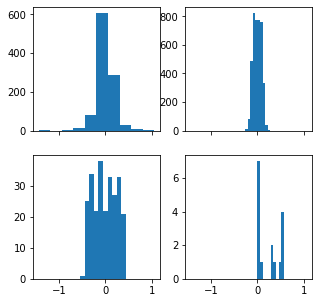

In [268]:
fig, axes = plt.subplots(2,2, figsize=(5,5),sharex=True)
(ax1,ax2,ax3,ax4) = axes.flatten()
_ = ax1.hist(cnn_model.get_weights()[0].ravel())
_ = ax2.hist(cnn_model.get_weights()[1].ravel())
_ = ax3.hist(cnn_model.get_weights()[2].ravel())
_ = ax4.hist(cnn_model.get_weights()[3].ravel())
plt.show()

In [269]:
print(np.array(cnn_model.get_weights())[0].min(),
np.array(cnn_model.get_weights())[1].min(),
np.array(cnn_model.get_weights())[2].min(),
np.array(cnn_model.get_weights())[3].min())

-1.4295524 -0.26470953 -0.5454456 0.00030090724


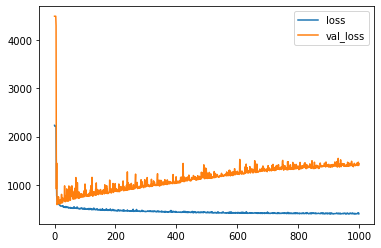

In [270]:
_ = plt.plot(history.history['loss'], label='loss')
_ = plt.plot(history.history['val_loss'], label='val_loss')
_ = plt.legend()
_ = plt.show()

There were 0 negative predictions
1-step MSE [Naive, CNN model] = [515.993717624597,399.38407198228754]
1-step R^2 [Naive, CNN model] = [0.7434099226462416,0.8056566716007996]


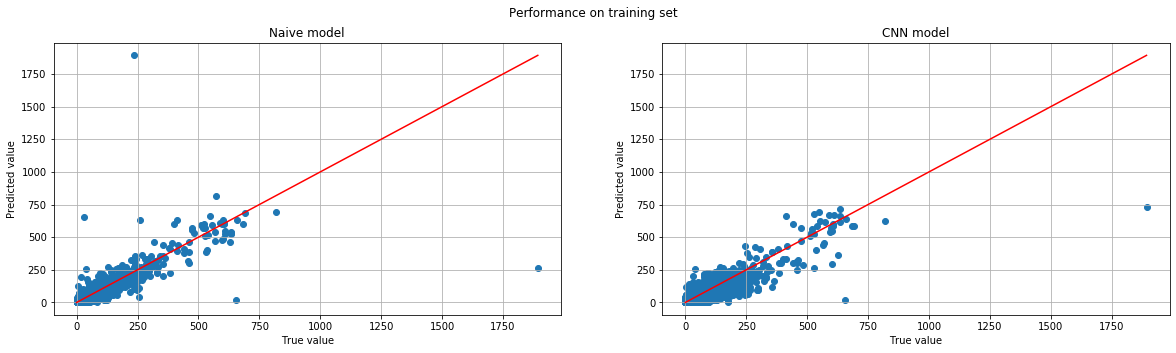

(16750,) (16750,) (16750,)


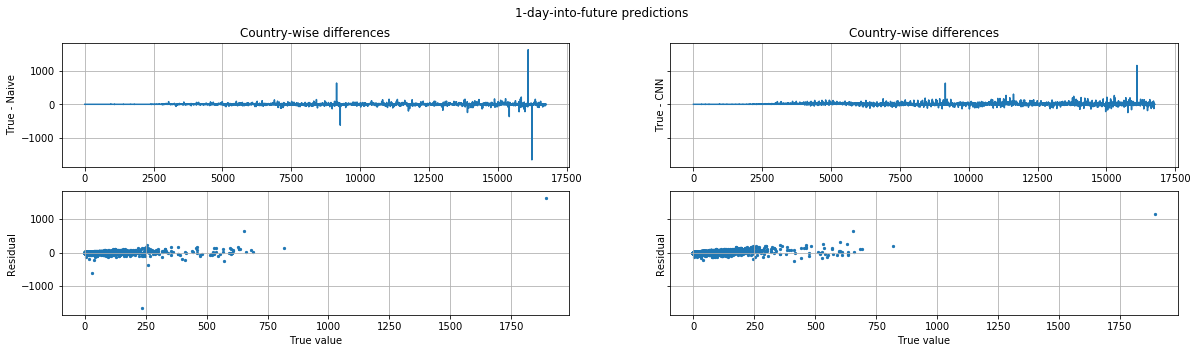

1892.582 1892.582 732.13904


In [271]:
y_true = y_cnn_train_model.ravel()
y_predict = cnn_model.predict(X_cnn_train_model).ravel()
model_analysis(y_true, y_train_naive, y_predict, n_countries, title='CNN model', suptitle='Performance on training set')
print(y_true.max(),y_train_naive.max(), y_predict.max())

There were 0 negative predictions
1-step MSE [Naive, CNN model] = [289.23349518763325,1437.4721623720216]
1-step R^2 [Naive, CNN model] = [0.9196333056324004,0.6079629522947161]


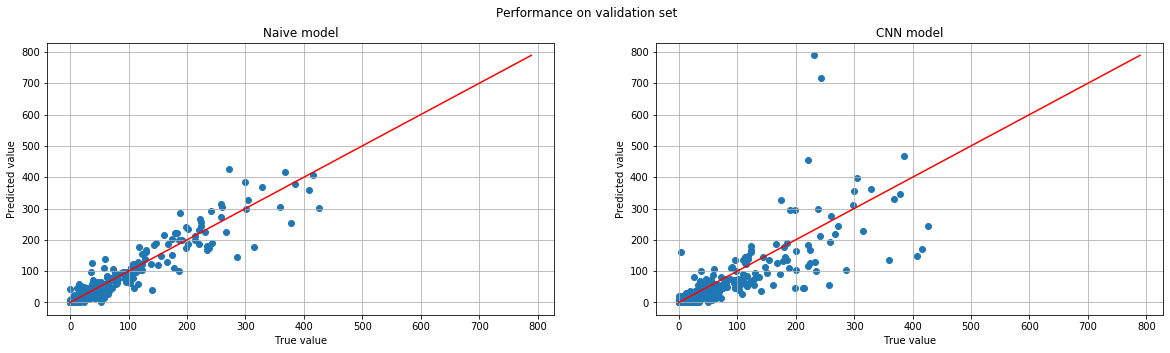

(938,) (938,) (938,)


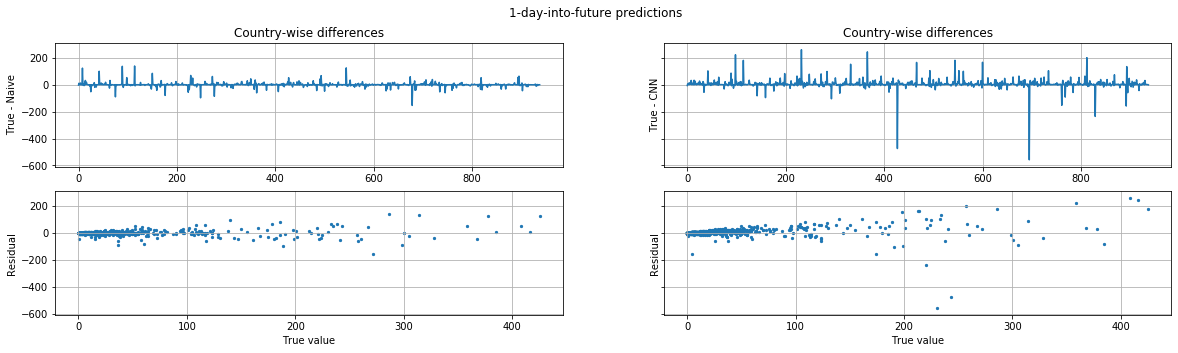

425.486 1892.582 789.1527


In [272]:
y_true = y_cnn_validate_model.ravel()
y_predict = cnn_model.predict(X_cnn_validate_model).ravel()
model_analysis(y_true, y_validate_naive, y_predict, n_countries, title='CNN model', suptitle='Performance on validation set')
print(y_true.max(),y_train_naive.max(), y_predict.max())

# scaled

In [274]:
# data = data[data.time_index>=40]
model_data = data.copy().iloc[:, 3:]
model_data =  model_data#.apply(lambda x :np.log(x+1))
new_cases_index = column_search(model_data,'new_cases_per_million', threshold='match', return_style='iloc')[0]
# model_data = model_data.iloc[:, new_cases_index].to_frame(); new_cases_index=0
n_countries = data.location.nunique()
target_data = model_data.new_cases_per_million
time_index = data.time_index

frame_size = 28
start_date = frame_size

n_validation_frames = 7
n_test_frames = 1
n_days_into_future = 1

In [275]:
X, y = create_Xy(model_data, target_data, time_index, start_date, frame_size, n_days_into_future, n_countries)
splits, indices = split_Xy(X, y, frame_size, n_validation_frames, n_test_frames)
# if need to supply folds for sklearn CV regression functions.
(X_train, y_train, X_validate, y_validate, X_test, y_test) = splits
(train_indices, validate_indices, test_indices) = indices

scaled_splits, frame_minmax, latest_minmax =  normalize_Xy_splits(splits, feature_range=(0,0.5), 
                                                                  normalization_method='minmax',
                                                                  train_test_only=False,
                                                                  feature_indices=None)
(latest_max, latest_min, latest_denom) = latest_minmax
(frame_max, frame_min, frame_denom) = frame_minmax
(X_cnn_train, y_cnn_train, X_cnn_validate, y_cnn_validate, X_cnn_test, y_cnn_test) = scaled_splits

splits_3d = concatenate_4d_into_3d(scaled_splits)
(X_cnn_train_model,y_cnn_train_model,X_cnn_validate_model,
 y_cnn_validate_model,X_cnn_test_model,y_cnn_test_model) = splits_3d

X_for_naive_slicing = np.concatenate(X.reshape(X.shape[0], X.shape[1], -1), axis=0)
n_features = X.shape[-1]
last_day_new_cases_index = np.ravel_multi_index([[frame_size-1],[new_cases_index]],(frame_size, n_features))
y_train_naive = X_for_naive_slicing[train_indices, last_day_new_cases_index].ravel()
y_validate_naive =  X_for_naive_slicing[validate_indices, last_day_new_cases_index].ravel()
y_test_naive =  X_for_naive_slicing[test_indices, last_day_new_cases_index].ravel()
# y_train_naive = (np.exp(X_for_naive_slicing[train_indices, last_day_new_cases_index])-1).ravel()
# y_validate_naive =  (np.exp(X_for_naive_slicing[validate_indices, last_day_new_cases_index])-1).ravel()
# y_test_naive =  (np.exp(X_for_naive_slicing[test_indices, last_day_new_cases_index])-1).ravel()

Starting with frame ranging time_index values: 0 27
Ending with frame ranging time_index values: 132 159


In [238]:
epochs = 1000
laearning_rate = 0.01
kernel = 4
N = 8
FC = 8
batch_size = 256

f1, f2 = 64, 16
k1, k2 = 4, 4

cnn_model = Sequential()
# kernel_initializer0=RandomUniform(minval=0.0, 
#                                  maxval= 1.0,
#                                  seed=0,
#                                 dtype=float)

cnn_model.add(Conv1D(filters=int(f1), kernel_size=int(k1),
                 padding='valid',
                 input_shape=X_cnn_train.shape[2:],
                 use_bias=False,
#                 kernel_constraint=non_neg(),
#                  activation='relu',
#                 kernel_initializer=kernel_initializer0
                )
         )

cnn_model.add(AveragePooling1D(pool_size=3))
# cnn_model.add(Activation('relu'))
# kernel_initializer1=RandomUniform(minval=0.0, 
#                                  maxval= 1.0,
#                                  seed=0,
#                                 dtype=float)

cnn_model.add(Conv1D(filters=int(f2), 
                 kernel_size=int(k2), 
                 padding='valid',
                 use_bias=False,
#                  kernel_constraint=non_neg(),

#                  activation='relu',
#                 kernel_initializer=kernel_initializer1
#                   use_bias=False
                )
         )


cnn_model.add(AveragePooling1D(pool_size=3))
# cnn_model.add(Activation('relu'))
cnn_model.add(Flatten())

# kernel_initializer2=RandomUniform(minval=0.0, 
#                                  maxval= 1.0,
#                                  seed=2,
#                                 dtype=float)

# cnn_model.add(Dense(, 
# #                 activation='relu',
#                 use_bias=False,
# #                  kernel_constraint=non_neg(),
# #                 kernel_initializer=kernel_initializer2
#                )
#          )

cnn_model.add(Dense(np.min([n_countries,cnn_model.output.shape[1]]),
#                 activation='relu',
                use_bias=False,
#                  kernel_constraint=non_neg(),
#                 kernel_initializer=kernel_initializer2
               )
         )

# kernel_initializer3=RandomUniform(minval=0.0, 
#                                  maxval= 1.0,
#                                  seed=0,
#                                 dtype=float)

cnn_model.add(Dense(1, 
                    activation='relu',
                    use_bias=False,
                     kernel_constraint=non_neg(),
#                     kernel_initializer=kernel_initializer3
                   ))
cnn_model.compile(loss='mse', optimizer=Adam(learning_rate=learning_rate))

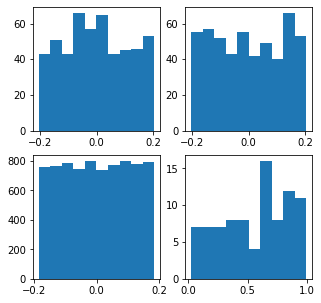

In [239]:
fig, axes = plt.subplots(2,2, figsize=(5,5))
(ax1,ax2,ax3,ax4) = axes.flatten()
_ = ax1.hist(cnn_model.get_weights()[0].ravel())
_ = ax2.hist(cnn_model.get_weights()[1].ravel())
_ = ax3.hist(cnn_model.get_weights()[2].ravel())
_ = ax4.hist(cnn_model.get_weights()[3].ravel())
plt.show()

In [240]:
history = cnn_model.fit(X_cnn_train_model, y_cnn_train_model, epochs=epochs, validation_data=(X_cnn_validate_model, y_cnn_validate_model), 
          batch_size=batch_size, verbose=1)

Train on 12998 samples, validate on 938 samples
Epoch 1/1000
12998/12998 [==============================] - 1s 93us/sample - loss: 2838.0989 - val_loss: 4459.9261
Epoch 2/1000
12998/12998 [==============================] - 0s 33us/sample - loss: 2774.5921 - val_loss: 4320.1480
Epoch 3/1000
12998/12998 [==============================] - 0s 32us/sample - loss: 2598.5750 - val_loss: 4005.7287
Epoch 4/1000
12998/12998 [==============================] - 0s 34us/sample - loss: 2312.0451 - val_loss: 3533.1527
Epoch 5/1000
12998/12998 [==============================] - 0s 32us/sample - loss: 1973.5375 - val_loss: 2988.4573
Epoch 6/1000
12998/12998 [==============================] - 0s 31us/sample - loss: 1692.8368 - val_loss: 2523.7206
Epoch 7/1000
12998/12998 [==============================] - 0s 31us/sample - loss: 1535.9840 - val_loss: 2249.6713
Epoch 8/1000
12998/12998 [==============================] - 0s 32us/sample - loss: 1456.9420 - val_loss: 2127.9414
Epoch 9/1000
12998/12998 [======

12998/12998 [==============================] - 0s 32us/sample - loss: 959.7953 - val_loss: 2636.3037
Epoch 72/1000
12998/12998 [==============================] - 0s 31us/sample - loss: 958.1968 - val_loss: 2636.2386
Epoch 73/1000
12998/12998 [==============================] - 0s 30us/sample - loss: 957.7250 - val_loss: 2627.3110
Epoch 74/1000
12998/12998 [==============================] - 0s 31us/sample - loss: 957.7589 - val_loss: 2617.8198
Epoch 75/1000
12998/12998 [==============================] - 0s 31us/sample - loss: 957.1172 - val_loss: 2627.6576
Epoch 76/1000
12998/12998 [==============================] - 0s 31us/sample - loss: 956.5388 - val_loss: 2633.7931
Epoch 77/1000
12998/12998 [==============================] - 0s 30us/sample - loss: 956.0400 - val_loss: 2620.7243
Epoch 78/1000
12998/12998 [==============================] - 0s 31us/sample - loss: 955.0430 - val_loss: 2604.9756
Epoch 79/1000
12998/12998 [==============================] - 0s 31us/sample - loss: 954.7896 -

Epoch 142/1000
12998/12998 [==============================] - 0s 31us/sample - loss: 931.4632 - val_loss: 2595.0768
Epoch 143/1000
12998/12998 [==============================] - 0s 31us/sample - loss: 931.1167 - val_loss: 2608.1915
Epoch 144/1000
12998/12998 [==============================] - 0s 30us/sample - loss: 930.7286 - val_loss: 2597.5528
Epoch 145/1000
12998/12998 [==============================] - 0s 32us/sample - loss: 930.9766 - val_loss: 2598.7278
Epoch 146/1000
12998/12998 [==============================] - 0s 31us/sample - loss: 930.3014 - val_loss: 2595.6876
Epoch 147/1000
12998/12998 [==============================] - 0s 31us/sample - loss: 930.0925 - val_loss: 2609.3207
Epoch 148/1000
12998/12998 [==============================] - 0s 31us/sample - loss: 931.2787 - val_loss: 2594.5461
Epoch 149/1000
12998/12998 [==============================] - 0s 30us/sample - loss: 929.7332 - val_loss: 2607.0777
Epoch 150/1000
12998/12998 [==============================] - 0s 30us/sa

12998/12998 [==============================] - 0s 32us/sample - loss: 907.0977 - val_loss: 2466.5289
Epoch 213/1000
12998/12998 [==============================] - 0s 31us/sample - loss: 907.2902 - val_loss: 2483.3000
Epoch 214/1000
12998/12998 [==============================] - 0s 30us/sample - loss: 906.0694 - val_loss: 2467.8120
Epoch 215/1000
12998/12998 [==============================] - 0s 30us/sample - loss: 907.2636 - val_loss: 2443.2924
Epoch 216/1000
12998/12998 [==============================] - 0s 30us/sample - loss: 904.9015 - val_loss: 2462.7197
Epoch 217/1000
12998/12998 [==============================] - 0s 30us/sample - loss: 905.0422 - val_loss: 2468.0775
Epoch 218/1000
12998/12998 [==============================] - 0s 31us/sample - loss: 904.3084 - val_loss: 2467.1050
Epoch 219/1000
12998/12998 [==============================] - 0s 30us/sample - loss: 903.7214 - val_loss: 2456.6690
Epoch 220/1000
12998/12998 [==============================] - 0s 30us/sample - loss: 90

Epoch 283/1000
12998/12998 [==============================] - 0s 31us/sample - loss: 888.9541 - val_loss: 2445.4450
Epoch 284/1000
12998/12998 [==============================] - 0s 31us/sample - loss: 887.4601 - val_loss: 2412.7272
Epoch 285/1000
12998/12998 [==============================] - 0s 30us/sample - loss: 888.9720 - val_loss: 2400.7978
Epoch 286/1000
12998/12998 [==============================] - 0s 31us/sample - loss: 887.2316 - val_loss: 2439.0509
Epoch 287/1000
12998/12998 [==============================] - 0s 31us/sample - loss: 887.1885 - val_loss: 2436.5153
Epoch 288/1000
12998/12998 [==============================] - 0s 31us/sample - loss: 886.8962 - val_loss: 2432.8902
Epoch 289/1000
12998/12998 [==============================] - 0s 31us/sample - loss: 886.9918 - val_loss: 2439.4077
Epoch 290/1000
12998/12998 [==============================] - 0s 31us/sample - loss: 887.2312 - val_loss: 2428.5101
Epoch 291/1000
12998/12998 [==============================] - 0s 32us/sa

12998/12998 [==============================] - 0s 33us/sample - loss: 881.5461 - val_loss: 2445.4569
Epoch 354/1000
12998/12998 [==============================] - 0s 32us/sample - loss: 880.8727 - val_loss: 2456.7747
Epoch 355/1000
12998/12998 [==============================] - 0s 32us/sample - loss: 880.9389 - val_loss: 2459.7153
Epoch 356/1000
12998/12998 [==============================] - 0s 33us/sample - loss: 881.8914 - val_loss: 2476.2192
Epoch 357/1000
12998/12998 [==============================] - 0s 32us/sample - loss: 881.5382 - val_loss: 2459.7679
Epoch 358/1000
12998/12998 [==============================] - 0s 32us/sample - loss: 881.2883 - val_loss: 2477.1256
Epoch 359/1000
12998/12998 [==============================] - 0s 33us/sample - loss: 881.0445 - val_loss: 2430.6035
Epoch 360/1000
12998/12998 [==============================] - 0s 31us/sample - loss: 881.1882 - val_loss: 2453.2873
Epoch 361/1000
12998/12998 [==============================] - 0s 31us/sample - loss: 88

Epoch 424/1000
12998/12998 [==============================] - 0s 29us/sample - loss: 876.9373 - val_loss: 2470.1708
Epoch 425/1000
12998/12998 [==============================] - 0s 30us/sample - loss: 877.1989 - val_loss: 2460.8957
Epoch 426/1000
12998/12998 [==============================] - 0s 29us/sample - loss: 876.5944 - val_loss: 2440.9512
Epoch 427/1000
12998/12998 [==============================] - 0s 30us/sample - loss: 877.3274 - val_loss: 2471.6864
Epoch 428/1000
12998/12998 [==============================] - 0s 29us/sample - loss: 876.5567 - val_loss: 2496.9656
Epoch 429/1000
12998/12998 [==============================] - 0s 32us/sample - loss: 876.7036 - val_loss: 2450.0319
Epoch 430/1000
12998/12998 [==============================] - 0s 29us/sample - loss: 877.1627 - val_loss: 2481.9674
Epoch 431/1000
12998/12998 [==============================] - 0s 29us/sample - loss: 876.4196 - val_loss: 2438.0968
Epoch 432/1000
12998/12998 [==============================] - 0s 30us/sa

12998/12998 [==============================] - 0s 30us/sample - loss: 872.5497 - val_loss: 2469.9690
Epoch 495/1000
12998/12998 [==============================] - 0s 29us/sample - loss: 872.3543 - val_loss: 2457.4490
Epoch 496/1000
12998/12998 [==============================] - 0s 30us/sample - loss: 872.4002 - val_loss: 2471.2603
Epoch 497/1000
12998/12998 [==============================] - 0s 30us/sample - loss: 873.1568 - val_loss: 2445.1359
Epoch 498/1000
12998/12998 [==============================] - 0s 30us/sample - loss: 872.2221 - val_loss: 2473.9571
Epoch 499/1000
12998/12998 [==============================] - 0s 29us/sample - loss: 872.6454 - val_loss: 2461.7277
Epoch 500/1000
12998/12998 [==============================] - 0s 30us/sample - loss: 872.4535 - val_loss: 2451.7882
Epoch 501/1000
12998/12998 [==============================] - 0s 29us/sample - loss: 872.6080 - val_loss: 2483.0663
Epoch 502/1000
12998/12998 [==============================] - 0s 30us/sample - loss: 87

Epoch 565/1000
12998/12998 [==============================] - 0s 30us/sample - loss: 869.0873 - val_loss: 2449.3022
Epoch 566/1000
12998/12998 [==============================] - 0s 30us/sample - loss: 868.1147 - val_loss: 2480.5237
Epoch 567/1000
12998/12998 [==============================] - 0s 30us/sample - loss: 868.2020 - val_loss: 2458.9643
Epoch 568/1000
12998/12998 [==============================] - 0s 31us/sample - loss: 868.5035 - val_loss: 2464.5820
Epoch 569/1000
12998/12998 [==============================] - 0s 31us/sample - loss: 868.1924 - val_loss: 2455.0960
Epoch 570/1000
12998/12998 [==============================] - 0s 30us/sample - loss: 869.3234 - val_loss: 2448.4556
Epoch 571/1000
12998/12998 [==============================] - 0s 30us/sample - loss: 868.2544 - val_loss: 2453.3917
Epoch 572/1000
12998/12998 [==============================] - 0s 30us/sample - loss: 868.6487 - val_loss: 2491.0684
Epoch 573/1000
12998/12998 [==============================] - 0s 28us/sa

12998/12998 [==============================] - 0s 32us/sample - loss: 865.2865 - val_loss: 2447.0170
Epoch 636/1000
12998/12998 [==============================] - 0s 30us/sample - loss: 864.8568 - val_loss: 2466.3251
Epoch 637/1000
12998/12998 [==============================] - 0s 30us/sample - loss: 864.5458 - val_loss: 2464.4681
Epoch 638/1000
12998/12998 [==============================] - 0s 30us/sample - loss: 864.6701 - val_loss: 2466.8143
Epoch 639/1000
12998/12998 [==============================] - 0s 29us/sample - loss: 864.8486 - val_loss: 2479.7444
Epoch 640/1000
12998/12998 [==============================] - 0s 30us/sample - loss: 865.1342 - val_loss: 2491.6977
Epoch 641/1000
12998/12998 [==============================] - 0s 30us/sample - loss: 864.7746 - val_loss: 2480.2204
Epoch 642/1000
12998/12998 [==============================] - 0s 30us/sample - loss: 865.1862 - val_loss: 2479.5514
Epoch 643/1000
12998/12998 [==============================] - 0s 30us/sample - loss: 86

12998/12998 [==============================] - 0s 31us/sample - loss: 862.1497 - val_loss: 2461.8496
Epoch 706/1000
12998/12998 [==============================] - 0s 32us/sample - loss: 860.9468 - val_loss: 2482.3321
Epoch 707/1000
12998/12998 [==============================] - 0s 31us/sample - loss: 861.0495 - val_loss: 2484.0919
Epoch 708/1000
12998/12998 [==============================] - 0s 31us/sample - loss: 862.1014 - val_loss: 2501.5676
Epoch 709/1000
12998/12998 [==============================] - 0s 29us/sample - loss: 860.6550 - val_loss: 2473.2434
Epoch 710/1000
12998/12998 [==============================] - 0s 28us/sample - loss: 861.2010 - val_loss: 2440.3612
Epoch 711/1000
12998/12998 [==============================] - 0s 29us/sample - loss: 860.6836 - val_loss: 2470.9161
Epoch 712/1000
12998/12998 [==============================] - 0s 31us/sample - loss: 861.1133 - val_loss: 2434.3985
Epoch 713/1000
12998/12998 [==============================] - 0s 29us/sample - loss: 85

Epoch 776/1000
12998/12998 [==============================] - 0s 31us/sample - loss: 856.3315 - val_loss: 2444.3220
Epoch 777/1000
12998/12998 [==============================] - 0s 31us/sample - loss: 856.5892 - val_loss: 2492.7282
Epoch 778/1000
12998/12998 [==============================] - 0s 32us/sample - loss: 856.3982 - val_loss: 2475.2277
Epoch 779/1000
12998/12998 [==============================] - 0s 31us/sample - loss: 856.5551 - val_loss: 2490.0099
Epoch 780/1000
12998/12998 [==============================] - 0s 32us/sample - loss: 855.8843 - val_loss: 2474.3919
Epoch 781/1000
12998/12998 [==============================] - 0s 33us/sample - loss: 856.2186 - val_loss: 2456.1015
Epoch 782/1000
12998/12998 [==============================] - 0s 31us/sample - loss: 856.1335 - val_loss: 2464.7413
Epoch 783/1000
12998/12998 [==============================] - 0s 32us/sample - loss: 855.9615 - val_loss: 2464.4695
Epoch 784/1000
12998/12998 [==============================] - 0s 31us/sa

12998/12998 [==============================] - 0s 30us/sample - loss: 853.6327 - val_loss: 2462.2976
Epoch 847/1000
12998/12998 [==============================] - 0s 30us/sample - loss: 852.3920 - val_loss: 2473.9725
Epoch 848/1000
12998/12998 [==============================] - 0s 30us/sample - loss: 852.8170 - val_loss: 2468.6172
Epoch 849/1000
12998/12998 [==============================] - 0s 31us/sample - loss: 852.0870 - val_loss: 2475.8233
Epoch 850/1000
12998/12998 [==============================] - 0s 30us/sample - loss: 853.0925 - val_loss: 2449.3142
Epoch 851/1000
12998/12998 [==============================] - 0s 31us/sample - loss: 853.0202 - val_loss: 2506.3525
Epoch 852/1000
12998/12998 [==============================] - 0s 32us/sample - loss: 853.4244 - val_loss: 2515.1591
Epoch 853/1000
12998/12998 [==============================] - 0s 31us/sample - loss: 851.8274 - val_loss: 2481.3749
Epoch 854/1000
12998/12998 [==============================] - 0s 31us/sample - loss: 85

Epoch 917/1000
12998/12998 [==============================] - 0s 31us/sample - loss: 847.6641 - val_loss: 2487.5900
Epoch 918/1000
12998/12998 [==============================] - 0s 32us/sample - loss: 847.5769 - val_loss: 2492.2134
Epoch 919/1000
12998/12998 [==============================] - 0s 31us/sample - loss: 847.4764 - val_loss: 2478.0238
Epoch 920/1000
12998/12998 [==============================] - 0s 30us/sample - loss: 847.9197 - val_loss: 2467.4337
Epoch 921/1000
12998/12998 [==============================] - 0s 31us/sample - loss: 848.0196 - val_loss: 2520.2612
Epoch 922/1000
12998/12998 [==============================] - 0s 30us/sample - loss: 848.2006 - val_loss: 2481.6297
Epoch 923/1000
12998/12998 [==============================] - 0s 31us/sample - loss: 848.1126 - val_loss: 2487.8702
Epoch 924/1000
12998/12998 [==============================] - 0s 32us/sample - loss: 848.0473 - val_loss: 2487.2760
Epoch 925/1000
12998/12998 [==============================] - 0s 31us/sa

12998/12998 [==============================] - 0s 32us/sample - loss: 843.9973 - val_loss: 2502.4254
Epoch 988/1000
12998/12998 [==============================] - 0s 32us/sample - loss: 843.7176 - val_loss: 2489.6036
Epoch 989/1000
12998/12998 [==============================] - 0s 34us/sample - loss: 843.7455 - val_loss: 2501.0908
Epoch 990/1000
12998/12998 [==============================] - 0s 32us/sample - loss: 843.3062 - val_loss: 2520.0969
Epoch 991/1000
12998/12998 [==============================] - 0s 33us/sample - loss: 843.1520 - val_loss: 2516.4028
Epoch 992/1000
12998/12998 [==============================] - 0s 32us/sample - loss: 843.1116 - val_loss: 2507.5637
Epoch 993/1000
12998/12998 [==============================] - 0s 32us/sample - loss: 843.4900 - val_loss: 2503.0746
Epoch 994/1000
12998/12998 [==============================] - 0s 32us/sample - loss: 843.4172 - val_loss: 2524.4449
Epoch 995/1000
12998/12998 [==============================] - 0s 32us/sample - loss: 84

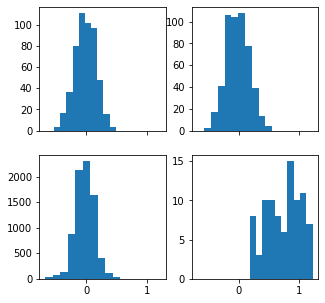

In [241]:
fig, axes = plt.subplots(2,2, figsize=(5,5),sharex=True)
(ax1,ax2,ax3,ax4) = axes.flatten()
_ = ax1.hist(cnn_model.get_weights()[0].ravel())
_ = ax2.hist(cnn_model.get_weights()[1].ravel())
_ = ax3.hist(cnn_model.get_weights()[2].ravel())
_ = ax4.hist(cnn_model.get_weights()[3].ravel())
plt.show()

In [242]:
print(np.array(cnn_model.get_weights())[0].min(),
np.array(cnn_model.get_weights())[1].min(),
np.array(cnn_model.get_weights())[2].min(),
np.array(cnn_model.get_weights())[3].min())

-0.529913 -0.5643492 -0.6746437 0.18161544


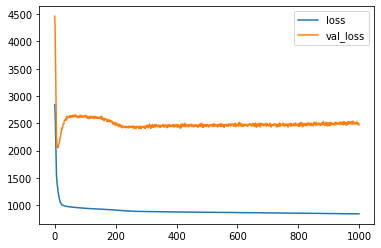

In [243]:
_ = plt.plot(history.history['loss'], label='loss')
_ = plt.plot(history.history['val_loss'], label='val_loss')
_ = plt.legend()
_ = plt.show()

There were 0 negative predictions
1-step MSE [Naive, CNN model] = [662.755655840437,841.847082649165]
1-step R^2 [Naive, CNN model] = [0.7367932424812904,0.6658371044141504]


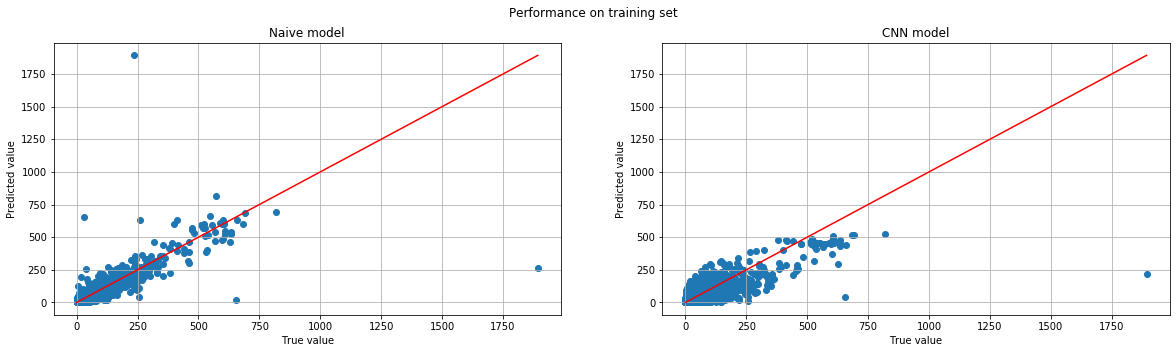

(12998,) (12998,) (12998,)


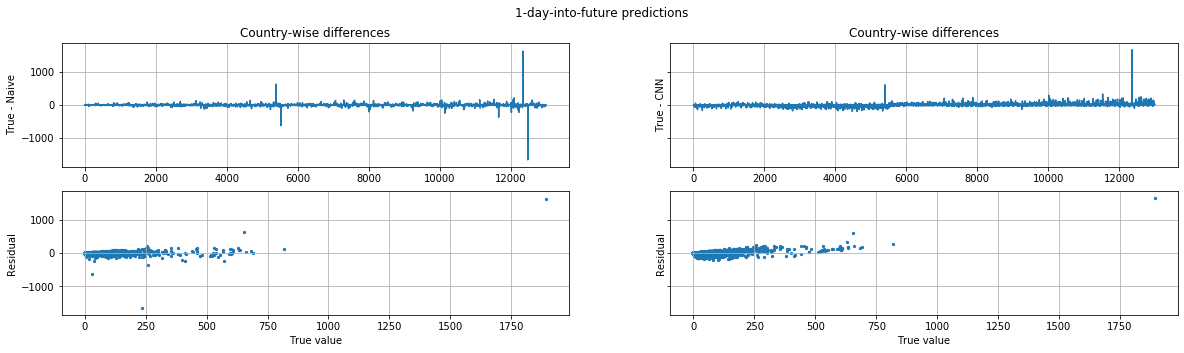

1892.582 1892.582 521.7799


In [244]:
y_true = y_cnn_train_model.ravel()
y_predict = cnn_model.predict(X_cnn_train_model).ravel()
model_analysis(y_true, y_train_naive, y_predict, n_countries, title='CNN model', suptitle='Performance on training set')
print(y_true.max(),y_train_naive.max(), y_predict.max())

There were 0 negative predictions
1-step MSE [Naive, CNN model] = [289.23349518763325,2470.5886435423863]
1-step R^2 [Naive, CNN model] = [0.9196333056324004,0.4473574680558762]


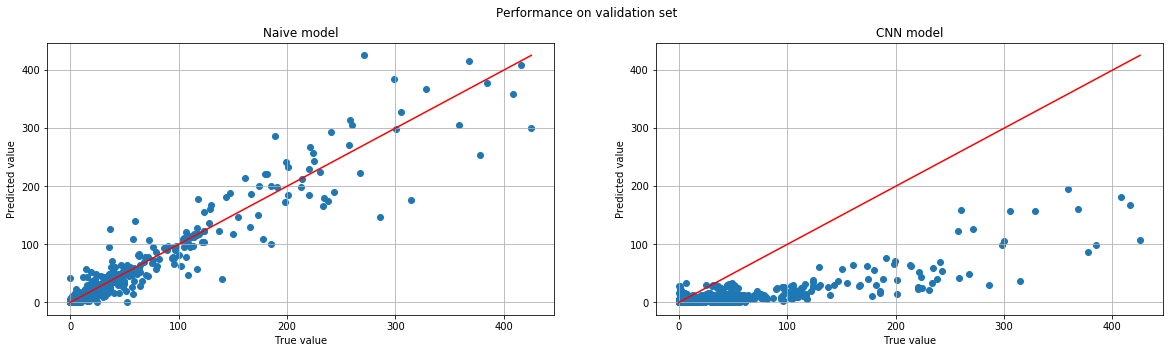

(938,) (938,) (938,)


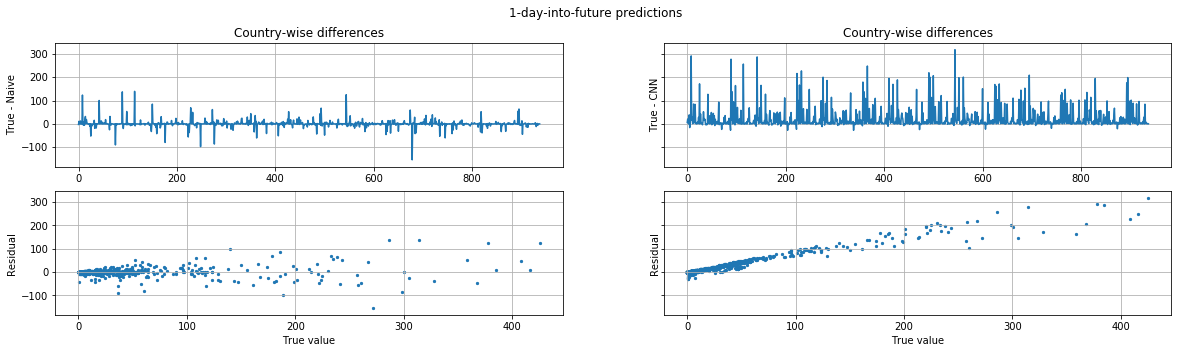

425.486 1892.582 194.76378


In [245]:
y_true = y_cnn_validate_model.ravel()
y_predict = cnn_model.predict(X_cnn_validate_model).ravel()
model_analysis(y_true, y_validate_naive, y_predict, n_countries, title='CNN model', suptitle='Performance on validation set')
print(y_true.max(),y_train_naive.max(), y_predict.max())

By iterating over possible leading window dates (window right edge, not inclusive),
a 4-d tensor with dimensions given by the following is created:
    
```(n_windows, n_countries, n_time_steps, n_features)```

Even if I don't use the input of this form, it makes it much easier to slice into train, validate and test, by slicing along
the ```n_windows``` axis. 

Note that if I also only wanted to include data from after the first case, that is possible by slicing data.time_index >= 1 

Putting this all together:


Now, splitting X intro train, validate, test, is as easy as slicing the first axis. Depending on how the CNN is set up, this
axis can later be flattened by simply applying ```np.concatenate(X_train, axis=0)```

Now, for the target data ```y```. To be as general as possible, I note that I should first shift the time series and combine them to store all of the data, and THEN manipulate it, i.e.

Assuming that ```X``` is of the shape ```(n_windows, n_countries, n_time_steps, n_features)```, the target data ```y``` should
be of shape ```(n_windows, n_countries)``` and the values for each slice of the first axis is then of shape ```(n_countries,)```, with the values equaling the ```model_data.n_cases_weighted``` value for ```time_index == window_right_edge_inclusive + n```, where n is the prediction step size. 

Because we need future values with which to measure error, the maximum that the leading window edge can be is always 

```model_data.time_index.max() - n```

In other words, because the maximum date value is

If I want to predict (and measure error) for 7 days in the future, the last window would have leading edge 
```model_data.time_index == 123```. 

For now, just test the waters with a 1-day prediction.
To do so, first split the X and y data into train, validate, test.
For the first attempt at a model, use Conv1D only, have to flatten the data with concatenations.
Before this, however, I want to rescale the data. Now, because each different element in the first axis is a different time range, the correct action is to (if normalizing) take the mean with respect to axis=1 and axis=2 ```n_countries``` and  ```n_time_steps```. This leaves a total number of averages of shape ```(n_windows, n_features)```, i.e. the mean and standard deviations for each feature for each date range. This ensures that no data snooping has occurred. To actually subtract and divide by these values, need to reform the same shape array (or at least that seems to be the easiest method to me.

Just to check, the slice [0, :, :, 0] should only contain one value.

Need to normalize only using the values up until frame; in fact, I only use the values inside each frame to normalize.
In the case of normalizing the validation and testing sets, use the most recent frame's means and standard deviation to normalize. This requires forming the correctly shaped array which is performed using np.tile()

Unfortunately there are values (actually a single value) where the standard deviation equals 0. Luckily, this
can be circumvented because the value of $X-\bar{X}$ is zero in the same place; i.e. I set $\sigma=1$ at that location, because
it doesn't actually affect the value.

Notes on results

    1. kernel small->large seems to work ok.
    2. filters
    3. pooling seems to hurt.

Create a 5-d tensor for convolution and FC layer parameters using itertools.
The layers of the CNN will remain the same throughout testing for now. That is, 

    1. Conv1D(f1, k1)
    2. Conv1D(f2, k2)
    3. Flatten
    4. Dense(d)
    5. Dense(1)) 

I don't know enough yet, but my intuition tells me that the overall trend (macroscopic picture)
is much more important to capture than microscopic. 
   
    f1 : number of filters,  first convolutional layer
    k1 : kernel size, first convolutional layer
    f1 : number of filters,  second convolutional layer
    k1 : kernel size, second convolutional layer
    d : number of nodes in hidden fully connected layer
    

I believe the naive baseline is performing so much better simply because of the growth in number of new cases; i.e. the model is training on smaller values and so in every prediction its underestimating. It's also predicting nearly the same values for each separate validation date, likely indicative of overfitting. 

Changing the activations and the layers seems to work much better than the number of filters and kernel size.

ReLU activation on both cd layers somehow increases the values, i.e. away from zero? how does that make sense.
Predicting non-negative quantity -> ReLU at eachy layer, otherwise model will try to use negative values which never do anything?

On the surface this performs worse but doesn't look like it's making ***terrible*** predictions. I'll show that I believe
that the model is indeed over-fitting. 

Relation between X slicing and the original data: 

    X[-1, :, -1, 2] = model_data.time_index.max() - n_days_into_future 
    X[-t, :, -1, 2] = (model_data.time_index.max() - n_days_into_future + 1) - t


### Data Format

Now I will discuss the data format which I have found the most useful. The motivation behind this formatting is that is has to be compatible with keras' convolution layers, respect ordering in time and hopefully be easy to use.

A "sample" or single input of the convolutional model is to be a single time window which I shall refer to as a frame. The output of the model will be a single day's worth of predictions, namely, the next day's number of cases, (with some experimentation into the forecasting range to be performed later). The Conv1D layers require that each sample be of two dimensional input ```(n_time_steps, n_features)```, but the training / testing sets themselves are passed as 3-D tensors of shape ```(all_train_or_test_frames, n_time_steps, n_features)```. In order to partition time in an easy manner, it is easier to first create a 4-D tensor, whose (first) axis can be thought of as indexing the leading edge of the time frames. Therefore, slicing into training, validation and testing, is a well ordered operation simply performed by slicing the tensor along this axis. (picture) ```(n_frames, n_countries, n_time_steps, n_features)```. It is also relatively straight forward how to manipulate the target variables and 

In [ ]:
print(X.shape) 
print(y.shape)

In [ ]:
t = (n_validation_frames + n_test_frames)
new_cases_weighted_index=0
((np.exp(X[-t, :, -1, new_cases_weighted_index])-1) - data[data.time_index == ((data.time_index.max() - n_days_into_future + 1) - t)].new_cases_weighted).sum()

And so to test the baseline, the predictions are of course the date on the RHS + n_days_into_future, or 

This proves the case where n_validate_frames == 1. Now try it for 7. This means that the "first" validation frame is t==8

Ok. Now to see if the baseline is actually what I think it is. There could be an issue into how I am calculating the loss.
This is calculating the loss of all batch frames simulataneously...? Each frame for each country makes a single prediction.
Should I be trying to group it only by frame though? I.e. 2-d input. 

In [ ]:
y_naive = X[-n_test_frames-1, :, -1,  new_cases_weighted_index]

In [ ]:
y - create_Xy(model_data, start_date, frame_size, n_days_into_future, n_countries)[1][-y.shape[0]:]

Somehow the relation between X and y is upheld (because of for loop?) they are not changing between n_days_into_future_changes. 

Emulate the last iteration of for loop.

What should be going on. For n_days_into_future = 7, X should be slicing data from time <= 123

Then, the data is reshaped to be an iterable of sequences of length max_date_in_window, which is then truncated.

For y. What should be happening? 

X is made such that its maximum date is  ```model_data.time_index.max() - n_days_into_future```. So by the very creation of
X, X and y are already staggered if y is sliced correctly. Which would be ```start_date + n_days_into_future : ```, or simply ```-X.shape[0]:```

X_test is the last frame. meaning that it currently contains t-14 information. y_test is the very last day, n_cases_per_million
un-normalized, so the naive model would be simply to use y_predict = X_test_original[:, -1, 2], this takes the values of the feature, new_cases_per_million, on the last day of the frame, for all countries.

SeperableConv2D model. I believe that time steps should be channels and then countries should be the rows...

Suprisingly, my first guess at the parameters was very close to the optimal setup.

In [ ]:
# print('The top 10 sets of parameters (k1,k2,f1,f2,d) are:\n')

# mae_rankings = pd.DataFrame(np.concatenate((parameter_grid[mae_list.argsort()],mae_list[mae_list.argsort()].reshape(-1,1)),axis=1), 
#              columns=['kernel_layer_1','kernel_layer_2','filter_layer_1','filter_layer_2','MAE'])
# mae_rankings.head()


In [ ]:
# mae_rankings.to_csv('conv_parameter_rankings.csv')

# best_param_predictions = predictions_list[mae_list.argsort()][0]

# pd.DataFrame(predictions_list[mae_list.argsort()]).to_csv('model_param_grid_predictions.csv')

In [ ]:
# pd.read_csv('conv_parameter_rankings.csv', index_col=0)

Because ```n_days_into_future == 1```, The most recent date in the last frame of X is data.time_index.max()-1.
The maximum date in y is data.time_index().max(). Therefore, to convert, we have
    
    X[-1,:,-1,:] = y[-2, :]
    
or, more generally, 

    X[-t,:,-1,:] = y[-(n+t), :]
    
testing this:

In [ ]:
# last_day_in_X = -1
# if last_day_in_X == -1:
#     last_day_in_X = None
# X_test_original = X[-16:last_day_in_X, :, -1, new_cases_weighted_index] 
# if last_day_in_X is None:
#     last_day_in_X = 0

# X_test_original - y[-(n_test_frames+n_days_into_future+X_test_original.shape[0]+last_day_in_X-1):
#                     -(n_days_into_future+last_day_in_X), :]

This shows that the staggering has been done correctly. That is, each entry along the first axis of X predicts.
Need to make sure that the naive predictions are being chosen correctly. To do so, just look at the instance
where n_frames_validation == 1 and n_frames_test == 1 (to make slicing easier) for n_days_into_future == 7.

Specifically, the shifting and comparison between y_validate and X_train isn't so hard as it follows the above formula.
This is prior to concatenation / squeezing / flattening the first axis.

    The following holds but this is not the predictions relation:   X[-t,:,-1,:] = y[-(n+t), :]
                                                  
    y has already been shifted to account for the n_days_into_future prediction. Therefore,     
    True future new_cases_weighted values : y[-t,:]. This is the n_days_into_future values.
    
    CNN predictions new_cases_weighted : model.predict(X[-t, :, :, :]). This predicts using the "present day" frame. 
    
    Naive predictions new_cases_weighted values: X[-t,:,-1, 2]. This takes the present day value from the last values of the frames.

Therefore, when n_validation_frames > 1.  are simply

    Naive predictions = X[validation_indices, :, -1, 2]
    CNN predictions = model.predict(X[validation_indices, :, :, :])
    True future values = y[validation_indices, :]
    
    Where validation indices is assumed to be a correctly formatted array of negative indices. 
    
    
    The last issue is the fact that X_validate is normalized and y values are not. Therefore, for the prediction X_validate is used, but for the naive baseline either the inverse normalized X_validation or just the original X should be used. Original
    X is actually easier because of 4-d index.

First, train and "test" without using the holdout test set. i.e. just use train and validation sets to test
This uses a single frame to validate (and test). Therefore, the naive model is formed by taking the frame of
X_validate and using its values for the prediction. The true values are stored in y_validate, the predicted values
are formed by using X_validate to predict, the naive values are the values in X_validate. 

Remember when slicing, the n_days_into_future buffer has already been factored into account. i.e. test
slicing is X[-n_test_frames:,:,:,:]

X time_index 130 is not used. X_test is 129, y_test is 130. X_validate is 126,127,128 y is 127,128,129.

In [ ]:
np.sqrt(1./(X_train.shape[0]/32))

from https://papers.nips.cc/paper/7320-how-many-samples-are-needed-to-estimate-a-convolutional-neural-network.pdf

To achieve error $\epsilon$ with filter number $m$ the number of samples needed is $\mathcal{O}(m/\epsilon^2)$

Let $\epsilon = 0.1$, then $100m$ = samples or $m = samples/100$. The number of samples is

It seems that included information from the too distant past actually makes the model worse. 

switching the order of countries and timesteps affects the following:
reshape A
kernel size B
kernal size AB
concatenate axis 1->2

If you have a convolution model. How is choosing a smaller frame size + kernel size different from
larger

The above model is the *only* one that hasn't underestimated values. There is still a lot of parameter tuning to be completed though:

The performance is the same up to small differences attributable to the individual trainings. 

In both models, the key difference between the predictions and the true values is that the ConvNet is having a hard
time picking up on dramatic spikes in the number of new cases. 